# Noisy and noiseless linear regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio

import typing
import os
import shutil
import sys

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPORT_DIR_NAME = 'teaser_plot_linreg'
LINREG_EXPERIMENT_NAME = 'teaser_plot_linreg'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPORT_DIR_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


In [6]:
FIGURE_SIZE = (2.75, 1.45)
LEGEND_FIGURE_SIZE = (3.2, 0.5)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT
AXIS_LABEL_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT
ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [7]:
robust_color_idx = 1
std_color_idx = 0
robust_linestyle_idx = 0
std_linestyle_idx = 2

In [8]:
client = mlflow.tracking.MlflowClient()
linreg_experiment = client.get_experiment_by_name(LINREG_EXPERIMENT_NAME)
linreg_runs = mlflow.search_runs(
    linreg_experiment.experiment_id
)
linreg_runs = linreg_runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
linreg_runs['params.data_dim'] = linreg_runs['params.data_dim'].astype(int)
linreg_runs['params.test_attack_epsilon'] = linreg_runs['params.test_attack_epsilon'].astype(np.float)
linreg_runs['params.l2_lambda'] = linreg_runs['params.l2_lambda'].astype(np.float)
linreg_runs['params.data_gaussian_noise_variance'] = linreg_runs['params.data_gaussian_noise_variance'].astype(np.float)
linreg_runs = linreg_runs.sort_values(['params.data_dim', 'params.l2_lambda', 'params.data_gaussian_noise_variance'], ascending=True)
print('Loaded', len(linreg_runs), 'runs of experiment', LINREG_EXPERIMENT_NAME)
assert linreg_runs['status'].eq('FINISHED').all()

Loaded 506 runs of experiment teaser_plot_linreg


In [9]:
num_samples, = linreg_runs['params.num_train_samples'].astype(int).unique()

nonoise, covariate_noise = np.sort(linreg_runs['params.data_gaussian_noise_variance'].unique())
assert nonoise == 0 and covariate_noise > 0

linreg_noiseless_runs = linreg_runs[linreg_runs['params.data_gaussian_noise_variance'] == 0]
linreg_noise_runs = linreg_runs[linreg_runs['params.data_gaussian_noise_variance'] > 0]

linreg_noreg_noiseless_runs = linreg_noiseless_runs[linreg_noiseless_runs['params.l2_lambda'] == 0]
linreg_bestreg_noiseless_runs = linreg_noiseless_runs.groupby('params.data_dim').aggregate({'metrics.true_std_risk': 'min', 'metrics.true_robust_risk': 'min'})

linreg_noreg_noise_runs = linreg_noise_runs[linreg_noise_runs['params.l2_lambda'] == 0]
linreg_bestreg_noise_runs = linreg_noise_runs.groupby('params.data_dim').aggregate({'metrics.true_std_risk': 'min', 'metrics.true_robust_risk': 'min'})

linreg_noiseless_std_gaps = linreg_noreg_noiseless_runs['metrics.true_std_risk'].values - linreg_bestreg_noiseless_runs['metrics.true_std_risk'].values
linreg_noiseless_robust_gaps = linreg_noreg_noiseless_runs['metrics.true_robust_risk'].values - linreg_bestreg_noiseless_runs['metrics.true_robust_risk'].values
linreg_noise_std_gaps = linreg_noreg_noise_runs['metrics.true_std_risk'].values - linreg_bestreg_noise_runs['metrics.true_std_risk'].values
linreg_noise_robust_gaps = linreg_noreg_noise_runs['metrics.true_robust_risk'].values - linreg_bestreg_noise_runs['metrics.true_robust_risk'].values

In [10]:
xticks = (0, 2, 4, 6, 8, 10)
y_axis_label = r'Risk($\lambda \to 0$) - Risk($\lambda_{\textnormal{opt}}$)'

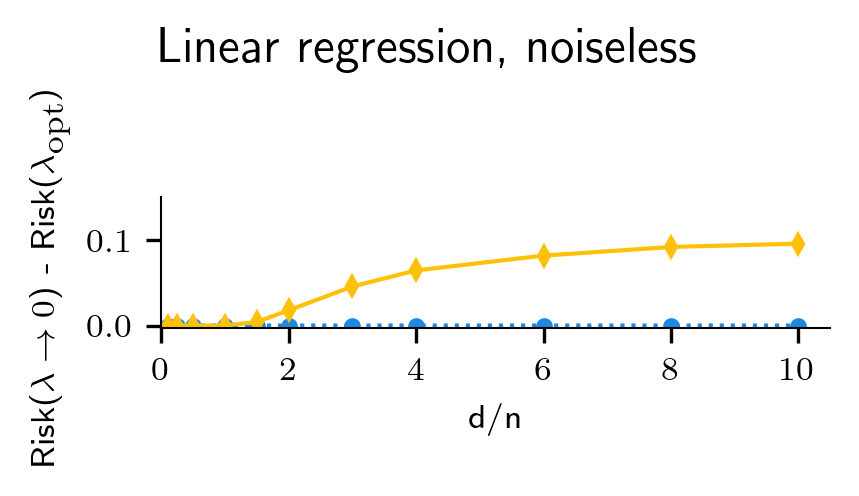

In [11]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

x_values = linreg_noreg_noiseless_runs[f'params.data_dim'].unique() / float(num_samples)

ax.plot(
    x_values,
    linreg_noiseless_std_gaps,
    label=r'Standard risk',
    ls=ir.plots.LINESTYLE_MAP[std_linestyle_idx],
    marker=ir.plots.MARKER_MAP[std_color_idx],
    c=f'C{std_color_idx}'
)

ax.plot(
    x_values,
    linreg_noiseless_robust_gaps,
    label=r'Robust risk',
    ls=ir.plots.LINESTYLE_MAP[robust_linestyle_idx],
    marker=ir.plots.MARKER_MAP[robust_color_idx],
    c=f'C{robust_color_idx}'
)

ax.set_xlabel('d/n', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylabel(y_axis_label, fontsize=AXIS_LABEL_FONT_SIZE, y=0.4)

ax.set_xticks(xticks)
ax.set_ylim(bottom=-0.0025, top=0.15)
ax.set_xlim(left=0)

if SHOW_TITLES:
    fig.suptitle('Linear regression, noiseless')

export_fig(fig, f'teaser_plot_linreg_noiseless.pdf')
plt.show()


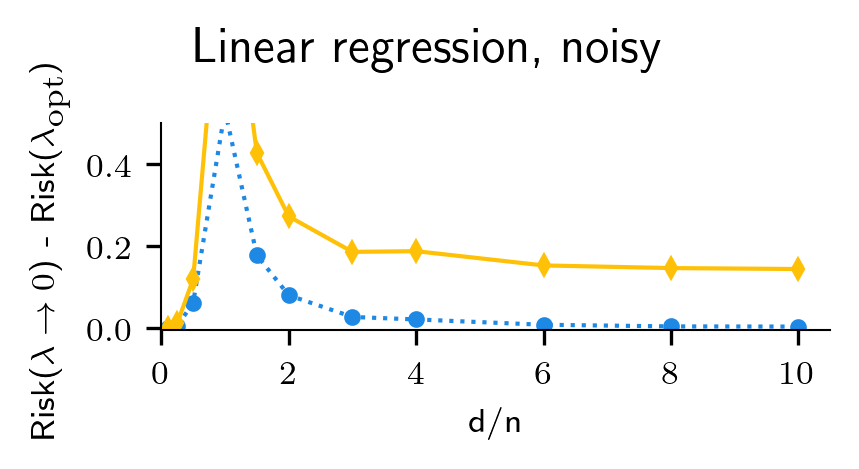

In [12]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

x_values = linreg_noreg_noise_runs[f'params.data_dim'].unique() / float(num_samples)

ax.plot(
    x_values,
    linreg_noise_std_gaps,
    label=r'Standard risk',
    ls=ir.plots.LINESTYLE_MAP[std_linestyle_idx],
    marker=ir.plots.MARKER_MAP[std_color_idx],
    c=f'C{std_color_idx}'
)

ax.plot(
    x_values,
    linreg_noise_robust_gaps,
    label=r'Robust risk',
    ls=ir.plots.LINESTYLE_MAP[robust_linestyle_idx],
    marker=ir.plots.MARKER_MAP[robust_color_idx],
    c=f'C{robust_color_idx}'
)

ax.set_xlabel('d/n', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylabel(y_axis_label, fontsize=AXIS_LABEL_FONT_SIZE, y=0.4)
ax.set_xticks(xticks)
ax.set_ylim(bottom=-0.005, top=0.5)
ax.set_xlim(left=0)

if SHOW_TITLES:
    fig.suptitle('Linear regression, noisy')

export_fig(fig, f'teaser_plot_linreg_noisy.pdf')
plt.show()


In [13]:
# Legend
legend_fig = plt.figure(figsize=LEGEND_FIGURE_SIZE)

handles, labels = ax.get_legend_handles_labels()
legend_fig.legend(
    handles,
    labels,
    loc='center',
    ncol=2,
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.5
)

export_fig(legend_fig, f'teaser_plot_linreg_legend.pdf')


<Figure size 960x150 with 0 Axes>